In [1]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras.layers import Embedding
from sklearn.metrics import roc_auc_score

In [2]:
dataset_names={0:"crisislex",1:"crisisnlp_crisismmd",2:"news_notNews",3:"Covid_WNUT", 4:"crisisnlp_Sandy_Japolin", 5:"crisisnlp_19Crisis", 6:"200 from Karabakh"}

In [3]:
all_files = glob.glob("../dataset_cleaning/*.pkl")
all_files.sort()
datasets = []

for filename in all_files:
    print(filename)
    df = pd.read_pickle(filename)
    datasets.append(df)



../dataset_cleaning/dataset1Cleaned.pkl
../dataset_cleaning/dataset2Cleaned.pkl
../dataset_cleaning/dataset3Cleaned.pkl
../dataset_cleaning/dataset4Cleaned.pkl
../dataset_cleaning/dataset5Cleaned.pkl
../dataset_cleaning/dataset6Cleaned.pkl
../dataset_cleaning/dataset7Cleaned.pkl


In [4]:
datasets[0].columns

Index(['id', 'Informativeness', 'text', 'positive_score', 'negative_score',
       'emotional_devergence_score'],
      dtype='object')

In [5]:
authors=pd.read_csv('../dataset_cleaning/tj/tweet_metadata_full.csv', index_col=0)
users=pd.read_csv('../dataset_cleaning/tj/twitter_user_full.csv',index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
users.drop(columns=['created_at', 'lang', 'name', 'screen_name', 'location','access'], inplace=True)
users.columns=['author_id', 'has_description', 'bio_has_url', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'statuses_count', 'protected',
       'verified', 'default_profile', 'default_profile_image']

In [7]:
mean=['retweet_count','favorite_count','followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']
median = ['tweet_type', 'has_description', 'bio_has_url', 'protected', 'verified','default_profile', 'default_profile_image']


for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    ds = pd.merge(ds, authors, on='id', how='left')

    ds.drop(ds.columns.difference(['id', 'Informativeness', 'text', 'positive_score', 'negative_score',
       'emotional_devergence_score', 'author_id', 'tweet_type', 'retweet_count', 'favorite_count']), 1, inplace=True)



    ds = pd.merge(ds, users, on='author_id', how='left')


    for m in mean:
        ds[m][ds['Informativeness'] == 1] = ds[m][ds['Informativeness'] == 1].fillna((ds[m][ds['Informativeness'] == 1].mean()))
        ds[m][ds['Informativeness'] == 0] = ds[m][ds['Informativeness'] == 0].fillna((ds[m][ds['Informativeness'] == 0].mean()))

    for m in median:
        ds[m][ds['Informativeness'] == 1] = ds[m][ds['Informativeness'] == 1].fillna((ds[m][ds['Informativeness'] == 1].value_counts().idxmax()))
        ds[m][ds['Informativeness'] == 0] = ds[m][ds['Informativeness'] == 0].fillna((ds[m][ds['Informativeness'] == 0].value_counts().idxmax()))

    ds["has_description"] = ds["has_description"].apply(lambda x: 0 if x is np.nan else 1)
    ds["tweet_type"] = ds["tweet_type"].apply(lambda x: 0 if x =='tweet' else 1)
    ds["bio_has_url"] = ds["bio_has_url"].apply(lambda x: 0 if x is np.nan else 1)
#     PUT THIS BACK
#     ds = ds.drop(columns=['id', 'author_id'])
    ds = ds.drop(columns=[ 'author_id'])


    datasets[i] = ds
    


Processing dataset 1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A valu

Processing dataset 2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing dataset 3
Processing dataset 4
Processing dataset 5
Processing dataset 6
Processing dataset 7


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A valu

In [8]:
datasets[0].columns

Index(['id', 'Informativeness', 'text', 'positive_score', 'negative_score',
       'emotional_devergence_score', 'tweet_type', 'retweet_count',
       'favorite_count', 'has_description', 'bio_has_url', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'statuses_count',
       'protected', 'verified', 'default_profile', 'default_profile_image'],
      dtype='object')

In [9]:

def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [10]:
def count_hashtags(text):
    return text.count('#')

In [11]:
def link_present(text):
    return int('http' in text) 

In [12]:
import emoji
def text_has_emoji(text):
    return any(map(text[:-50].__contains__, [':)',':(',':P',':c',':<','c:','<:',':L',':l','^_^','^.^','>_<','>.<','>_>','<_<','>.>','<.<','-.-','-_-','o_o','o.o','._.','owo','OwO',';_;','>:)',':]',':}','>:(','>:|','-.^','-_^','8)','B)','<3','xD',':3','x3','\o','\o/',';_;','OwO','uwu','O:)',':#',':*']))

In [13]:
def has_instructional_words(text):
    return any(map(text.__contains__, ["text", 'call', 'donate']))

In [14]:
def has_phone_number(text):
    return bool(re.search('\\d{3}-\\d{3}-\\d{4}', text))

In [15]:
def text_has_slang(text):
    for i in text[:-50].split(' '):
        for j in ['afaik','afk','asl','atm','atw','ayy','bae','bb','bbiab','bbl','bbs','bc','bf','bff','bork','brb','btw','cba','convo','cp','cya','cya','dank','dc','dem','dw','e2e','fml','FOMO','FTFY','ftl','ftw','fwiw','fyi','g2g','g4u','gf','gg','goml','gr8','gratz','gtfo','guiz','hbu','hru','ianadb','ianalb','ianap','idc','idgaf','idk','iirc','ik','ikr','ily','inb4','irl','jfc','jk','js','k','kappa','kek','kms','kthx','l8r','leet','lmao','lmk','lol','LPT','lrl','lrn2','m8','maga','mfw','mrw','nerf','ngl','nm','nmu','noob','nvm','ofc','omf','omg','omw','ooc','op','OP','orly','pepe','pleb','pleb','plz','pron','pwned','REEEEEE','rekt','rickrol','rip','rly','rms','rofl','rotflol','rtfm','rude','shank','smd','smh','soz','swag','tbf','tbh','tbt','TIFU','tf','tfw','thx','tide','TIL','tl;dr','tmw','tolo','topkek','ty','uwotm8','w00t','wb','wot','wtb','wtf','wtg','wts','wuu2','yarly','ymmv','yolo','yw']:
            if(i==j):
                return True
    return False

In [16]:
def is_RT(text):
    for i in text[:-50].split(' '):
        if(i == 'RT'):
            return True
    return False

In [17]:
def has_profanity(text):
    for i in text[:-50].split(' '):
        for j in ['acrotomophilia','anal','anilingus','anus','arsehole','ass','asshole','assmunch','auto erotic','autoerotic','babeland','baby batter','ball gag','ball gravy','ball kicking','ball licking','ball sack','ball sucking','bangbros','bareback','barely legal','barenaked','bastardo','bastinado','bbw','bdsm','beaver cleaver','beaver lips','bestiality','bi curious','big black','big breasts','big knockers','big tits','bimbos','birdlock','bitch','black cock','blonde action','blonde on blonde action','blow j','blow your l','blue waffle','blumpkin','bollocks','bondage','boner','boob','boobs','booty call','brown showers','brunette action','bukkake','bulldyke','bullet vibe','bung hole','bunghole','busty','butt','buttcheeks','butthole','camel toe','camgirl','camslut','camwhore','carpet muncher','carpetmuncher','chocolate rosebuds','circlejerk','cleveland steamer','clit','clitoris','clover clamps','clusterfuck','cock','cocks','coprolagnia','coprophilia','cornhole','cum','cumming','cunnilingus','cunt','darkie','date rape','daterape','deep throat','deepthroat','dick','dildo','dirty pillows','dirty sanchez','dog style','doggie style','doggiestyle','doggy style','doggystyle','dolcett','domination','dominatrix','dommes','donkey punch','double dong','double penetration','dp action','eat my ass','ecchi','ejaculation','erotic','erotism','escort','ethical slut','eunuch','faggot','fecal','felch','fellatio','feltch','female squirting','femdom','figging','fingering','fisting','foot fetish','footjob','frotting','fuck','fucking','fuck buttons','fudge packer','fudgepacker','futanari','g-spot','gang bang','gay sex','genitals','giant cock','girl on','girl on top','girls gone wild','goatcx','goatse','gokkun','golden shower','goo girl','goodpoop','goregasm','grope','group sex','guro','hand job','handjob','hard core','hardcore','hentai','homoerotic','honkey','hooker','hot chick','how to kill','how to murder','huge fat','humping','incest','intercourse','jack off','jail bait','jailbait','jerk off','jigaboo','jiggaboo','jiggerboo','jizz','juggs','kike','kinbaku','kinkster','kinky','knobbing','leather restraint','leather straight jacket','lemon party','lolita','lovemaking','make me come','male squirting','masturbate','menage a trois','milf','missionary position','motherfucker','mound of venus','mr hands','muff diver','muffdiving','nambla','nawashi','negro','neonazi','nig nog','nigga','nigger','nimphomania','nipple','nipples','nsfw images','nude','nudity','nympho','nymphomania','octopussy','omorashi','one cup two girls','one guy one jar','orgasm','orgy','paedophile','panties','panty','pedobear','pedophile','pegging','penis','phone sex','piece of shit','piss pig','pissing','pisspig','playboy','pleasure chest','pole smoker','ponyplay','poof','poop chute','poopchute','porn','porno','pornography','prince albert piercing','pthc','pubes','pussy','queaf','raghead','raging boner','rape','raping','rapist','rectum','reverse cowgirl','rimjob','rimming','rosy palm','rosy palm and her 5 sisters','rusty trombone','s&m','sadism','scat','schlong','scissoring','semen','sex','sexo','sexy','shaved beaver','shaved pussy','shemale','shibari','shit','shota','shrimping','slanteye','slut','smut','snatch','snowballing','sodomize','sodomy','spic','spooge','spread legs','strap on','strapon','strappado','strip club','style doggy','suck','sucks','suicide girls','sultry women','swastika','swinger','tainted love','taste my','tea bagging','threesome','throating','tied up','tight white','tit','tits','titties','titty','tongue in a','topless','tosser','towelhead','tranny','tribadism','tub girl','tubgirl','tushy','twat','twink','twinkie','two girls one cup','undressing','upskirt','urethra play','urophilia','vagina','venus mound','vibrator','violet blue','violet wand','vorarephilia','voyeur','vulva','wank','wet dream','wetback','white power','women rapping','wrapping men','wrinkled starfish','xx','xxx','yaoi','yellow showers','yiffy','zoophilia']:
            if(i==j):
                return True
    return False


In [18]:
def one_word_sentance(text):
    return int(len(text.split(" "))<=3)

In [19]:
datasets[0].head()

,id,Informativeness,text,positive_score,negative_score,emotional_devergence_score,tweet_type,retweet_count,favorite_count,has_description,bio_has_url,followers_count,friends_count,favourites_count,listed_count,statuses_count,protected,verified,default_profile,default_profile_image
0,211040709124440064,0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,1,-1,0.2,0,0,-1,1,1,62,19,0,0.0,402,False,False,True,True
1,210864180218167296,0,Get in on the fun every Thursday with the @csi...,2,-1,0.3,0,2,-1,1,1,454,35,2,28.0,3327,False,False,False,False
2,211157222699433985,0,Welcome to our newest STUDENTathlete- Reagan B...,2,-1,0.3,0,0,0,1,1,1,1,0,0.0,422,False,False,True,True
3,211162553659830272,0,Denver Post: #Colorado governor signs bill cre...,1,-1,0.2,0,0,-1,1,1,1965,188,0,181.0,4392,False,False,False,False
4,211216962162933761,0,Pretty sure I'm going to live in Manitou Sprin...,3,-1,0.4,0,0,-1,1,1,227,203,23,2.0,3687,False,False,True,False


In [20]:
from tqdm import tqdm
tqdm.pandas()
for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    
    
    ds["hashtag_count"]=ds['text'].apply(count_hashtags)

    ds["hashtag_present"] = ds["hashtag_count"].apply(lambda x: np.sign(x))

    ds["link_present"]=ds['text'].apply(link_present)

    ds["emoji_present"] = ds['text'].apply(text_has_emoji)

    ds["instructinal_keyword"] = ds['text'].apply(has_instructional_words)

    ds["contains_phone_number"] = ds['text'].apply(has_phone_number)

    ds["slang_present"] = ds['text'].apply(text_has_slang)

    ds["is_RT"] = ds['text'].apply(is_RT)

    ds["has_profanity"] = ds['text'].apply(has_profanity)

    ds["one_word_sentance"] = ds['text'].apply(one_word_sentance)
    
    ds['text']=ds['text'].progress_apply(text_processing)

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Processing dataset 1


100%|██████████| 18154/18154 [00:52<00:00, 344.57it/s]


Processing dataset 2


100%|██████████| 15745/15745 [00:40<00:00, 392.32it/s]


Processing dataset 3


100%|██████████| 2522/2522 [00:11<00:00, 221.73it/s]


Processing dataset 4


  4%|▍         | 37/826 [00:00<00:02, 362.50it/s]

Processing dataset 5


100%|██████████| 826/826 [00:02<00:00, 336.22it/s]


Processing dataset 6


 10%|▉         | 19/194 [00:00<00:00, 186.48it/s]

Processing dataset 7


100%|██████████| 194/194 [00:01<00:00, 189.39it/s]


In [21]:
for i,ds in enumerate(datasets):
    print("Dropping not needed columns for dataset {}".format(i+1))
    datasets[i]=ds.drop(ds.columns.difference(['Informativeness', 'text', 'positive_score', 'negative_score',
       'emotional_devergence_score', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'statuses_count', 'verified',
       'hashtag_count', 'hashtag_present', 'link_present',
       'emoji_present', 'instructinal_keyword', 'contains_phone_number',
       'slang_present', 'is_RT', 'has_profanity', 'one_word_sentance']), 1)

Dropping not needed columns for dataset 1
Dropping not needed columns for dataset 2
Dropping not needed columns for dataset 3
Dropping not needed columns for dataset 4
Dropping not needed columns for dataset 5
Dropping not needed columns for dataset 6
Dropping not needed columns for dataset 7


In [22]:
from sentence_transformers import SentenceTransformer
st_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

EMBEDDING_DIM=768

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [23]:
def build_cnn_model(X_train ):
    sequence_length = X_train.shape[1]

    filter_sizes = [3,4,5]
    num_filters = 150
    drop = 0.5



    inputs = Input(shape=(sequence_length,))


    meta_input = Input(shape=(19,))
    embedding = embedding_layer(inputs)
    reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)


    conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
    conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
    conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

    maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
    maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
    maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
    flatten = Flatten()(merged_tensor)
    reshape = Reshape((3*num_filters,))(flatten)
    dropout = Dropout(drop)(flatten)
    merged_tensor2 = concatenate([dropout, meta_input])

    output = Dense(units=2, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(merged_tensor2)



    return Model([inputs , meta_input], output)

In [24]:
results=[]
for i,ds_train in enumerate(datasets):

    print("----Training on Dataset {}----".format(i+1))
    row=[]

    train=ds_train
    texts=train.text
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                          lower=True)
    tokenizer.fit_on_texts(texts)
    sequences_train = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    X_train = pad_sequences(sequences_train)
    y_train = np.asarray(train.Informativeness)
    print('Shape of X train :', X_train.shape)
    print('Shape of label train :', y_train.shape)
    print("Computing embedding matrix")
    vocabulary_size=len(word_index)+1
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        try:
            embedding_vector = st_model.encode(word)
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)



    embedding_layer = Embedding(vocabulary_size,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                trainable=True)
    
    model= build_cnn_model(X_train)

    y_train = y_train.reshape(len(y_train), 1)

    y_train_extra = np.abs(y_train-1)

    X_train_meta = train.to_numpy()[:, 2:].astype('float32')
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    callbacks = [EarlyStopping(monitor='loss')]
    model.fit([X_train, X_train_meta], np.append(y_train, y_train_extra, axis=1), batch_size=1000, epochs=10, verbose=1,
             callbacks=callbacks)  

    for j,ds_test in enumerate(datasets):

        print("testing on Dataset {}".format(j+1))

        test=ds_test
        sequences_test=tokenizer.texts_to_sequences(test.text)
        X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])
        X_test_meta = test.to_numpy()[:, 2:].astype('float32')
        y_pred=model.predict([X_test, X_test_meta])
        y_pred_bool =(y_pred > 0.5).astype("int32")
        y_true = np.asarray(test.Informativeness).reshape(len(test),1)

        row.append(roc_auc_score(y_true, y_pred_bool[:,0]))
    results.append(row)




----Training on Dataset 1----
Found 18035 unique tokens.
Shape of X train : (18154, 26)
Shape of label train : (18154,)
Computing embedding matrix
Epoch 1/10
19/19 [==============================] - 84s 4s/step - loss: 30663.0723 - acc: 0.5547
Epoch 2/10
19/19 [==============================] - 90s 5s/step - loss: 2622.2881 - acc: 0.6250
Epoch 3/10
19/19 [==============================] - 93s 5s/step - loss: 2168.0896 - acc: 0.6230
Epoch 4/10
19/19 [==============================] - 93s 5s/step - loss: 1643.3083 - acc: 0.6389
Epoch 5/10
19/19 [==============================] - 93s 5s/step - loss: 892.8536 - acc: 0.6493
Epoch 6/10
19/19 [==============================] - 81s 4s/step - loss: 234.2279 - acc: 0.7026
Epoch 7/10
19/19 [==============================] - 78s 4s/step - loss: 73.4936 - acc: 0.7507
Epoch 8/10
19/19 [==============================] - 91s 5s/step - loss: 52.3903 - acc: 0.7689
Epoch 9/10
19/19 [==============================] - 74s 4s/step - loss: 45.1125 - acc: 0.7

In [25]:
results

[[0.793500145029995,
  0.5795199050999724,
  0.6669939767628116,
  0.542677623097733,
  0.5798214343064522,
  0.5895309369646642,
  0.650817527795945],
 [0.6696190063290143,
  0.6672564771679453,
  0.6905376754034691,
  0.5099985932891211,
  0.7046407810643286,
  0.6936604386245077,
  0.6121648136036625],
 [0.5933802839739939,
  0.495516807389506,
  0.5592175277299308,
  0.5181944712688238,
  0.5028326428364969,
  0.4748494889811562,
  0.555134074558535],
 [0.4498098301896777,
  0.48998422015842114,
  0.44439682600634145,
  0.5101624329817791,
  0.4988855702219224,
  0.5160559120428171,
  0.45794637017658596],
 [0.49818167906217803,
  0.48679420113422006,
  0.48367815177680007,
  0.49305436503534583,
  0.49984905417991454,
  0.483018386516071,
  0.4970568999345978],
 [0.5618121193260951,
  0.544978273840016,
  0.5802049162342151,
  0.4865231800295052,
  0.5936763336223785,
  0.627998787782004,
  0.5305428384565075],
 [0.5287723414109899,
  0.6275645004791206,
  0.5559789406124173,
  0.

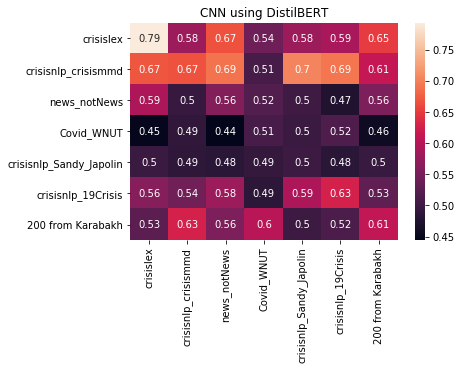

In [26]:
df = pd.DataFrame(results)
df.columns= map( lambda x: dataset_names[x],df.columns)
df.index= map( lambda x: dataset_names[x],df.index)
svm=sns.heatmap(df, annot=True).set_title("CNN using DistilBERT")